<a href="https://colab.research.google.com/github/ehas1/Statistical-Bias-in-ML/blob/main/OAIP_Skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# imports
import pandas as pd
import requests
from io import StringIO
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss
from graphviz import Digraph
from joblib import dump, load

In [59]:
# define functions

def load_data(
    url: str = "https://raw.githubusercontent.com/propublica/compas-analysis/refs/heads/master/cox-violent-parsed.csv"
    ) -> pd.DataFrame:
    """Download COMPAS data set from Github to current directory. (Add a copy of
    the file to your repository and download it from there.) Then load file into
    RAM."""

    response = requests.get(url)
    data = pd.read_csv(StringIO(response.text))

    return data

def preprocess_data(data: pd.DataFrame, random_state: int = 42) -> tuple:
    """Preprocess COMPAS data set. Include feature grabbing, string parsing, 1-hot
    encoding, train-test split and feature normalization."""

       # Remove invalid recidivism records and select features
    data = data[data['is_recid'] != -1]
    features = ["sex", "age", "race", "juv_fel_count", "juv_misd_count",
                "juv_other_count", "priors_count", "c_charge_degree"]
    X = data[features].copy()  # Create an explicit copy
    y = data['is_recid']

    # Categorize charge degree
    X.loc[:, 'c_charge_degree'] = X['c_charge_degree'].fillna('Other')
    X.loc[:, 'c_charge_degree'] = X['c_charge_degree'].apply(
        lambda x: 'Felony' if str(x).startswith('F') else
                 'Misdemeanor' if str(x).startswith('M') else 'Other'
    )

    # One-hot encode categorical features
    X_encoded = pd.get_dummies(X, columns=['sex', 'race', 'c_charge_degree'])

    # Normalize numerical features
    numerical_features = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
    for col in numerical_features:
        min_val = X_encoded[col].min()
        max_val = X_encoded[col].max()
        if max_val > min_val:
            X_encoded[col] = (X_encoded[col] - min_val) / (max_val - min_val)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2,
                                                        random_state=random_state)

    return [X_train, y_train], [X_test, y_test]


def train_decision_tree(train_data: list, params: dict = None) -> DecisionTreeClassifier:
    """Decision tree training on full training data set."""
    X_train, y_train = train_data
    if params is None:
      params = {}
    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)
    return model

def tree_viz(model: object) -> plt.figure:
    """Create a visualization of a decision tree."""
    # Create directed graph
    fig = Digraph(comment='Decision Tree Visualization')
    fig.attr(rankdir='TB')  # Top to bottom layout

    # Set visualization style
    fig.attr('node', shape='box', style='rounded,filled', fillcolor='lightblue')
    fig.attr('edge', color='gray50')
    fig.attr(bgcolor='white')

    # Get tree structure
    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    value = model.tree_.value

    # Create nodes with simplified information
    for node_id in range(n_nodes):
        if children_left[node_id] == -1:  # Leaf node
            prob = value[node_id][0, 1] / value[node_id].sum()
            color = 'lightpink' if prob >= 0.5 else 'lightgreen'
            label = f'Prediction: {"Yes" if prob >= 0.5 else "No"}'
            fig.node(str(node_id), label, fillcolor=color)
        else:  # Decision node
            feat_name = model.feature_names_in_[feature[node_id]]
            split_value = threshold[node_id]

            # Format the split value based on feature type
            if feat_name in ['sex_Female', 'sex_Male'] or feat_name.startswith('race_') or feat_name.startswith('c_charge_degree_'):
                # For one-hot encoded features, show as is (0 or 1)
                label = f'{feat_name}\n= {int(split_value)}'
            else:
                # For numerical features, show as integers if they're counts
                if feat_name in ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']:
                    label = f'{feat_name}\n≤ {int(round(split_value))}'
                else:  # For age, keep one decimal place
                    label = f'{feat_name}\n≤ {int(round(split_value * 100))}'

            fig.node(str(node_id), label)

            # Add edges to children with Yes/No labels
            fig.edge(str(node_id), str(children_left[node_id]), 'Yes')
            fig.edge(str(node_id), str(children_right[node_id]), 'No')

    # Set graph size and font
    fig.attr(size='12,12')
    fig.attr(fontsize='10')

    return fig


def test_model(model: DecisionTreeClassifier, data: list) -> dict:
    """Test a given model (is it a classifier or a regressor?). Include all
    metrics that you want to use in later analyses. This may include accuracy,
    loss, TPR, FPR, etc. Return them as a dictionary."""

    X_test, y_test = data
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability of positive class

    # Calculate confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    evals = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),  # Same as TPR
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'loss': log_loss(y_test, y_prob),
        'tpr': tp / (tp + fn),  # True Positive Rate
        'fpr': fp / (fp + tn),  # False Positive Rate
        'tnr': tn / (tn + fp),  # True Negative Rate
        'fnr': fn / (fn + tp),  # False Negative Rate
    }

    return evals


def plot_evals(evals: dict) -> plt.figure:
    """Show training and test accuracy as a function of number of epochs. Includes other metrics"""

    # Set style
    sns.set_style('whitegrid')
    plt.rcParams['figure.figsize'] = (12, 4)

    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    # Plot 1: Accuracy metrics
    metrics1 = ['accuracy', 'precision', 'recall', 'f1']
    values1 = [evals[m] for m in metrics1]
    sns.barplot(x=metrics1, y=values1, ax=ax1)
    ax1.set_title('Accuracy Metrics')
    ax1.set_ylim(0, 1)

    # Plot 2: Error rates
    metrics2 = ['tpr', 'fpr', 'tnr', 'fnr']
    values2 = [evals[m] for m in metrics2]
    sns.barplot(x=metrics2, y=values2, ax=ax2)
    ax2.set_title('Error Rates')
    ax2.set_ylim(0, 1)

    # Plot 3: ROC-AUC and Loss
    metrics3 = ['roc_auc', 'loss']
    values3 = [evals[m] for m in metrics3]
    sns.barplot(x=metrics3, y=values3, ax=ax3)
    ax3.set_title('ROC-AUC & Loss')

    # Adjust layout
    plt.tight_layout()

    return fig


def train_decision_tree_with_crossvalidation(train_data: list,
  n_fold: int = 5, params: dict = None, shuffle=True, random_state=42) -> dict:
  """Split training data into folds, loops over held-out folds for training
  rounds, calculates and stores performance metrics for each run of the loop as
  a function of the number of epochs. Return a dictionary of validation evals."""

  X_train, y_train = train_data
  kf = KFold(n_splits=n_fold, shuffle=shuffle, random_state=random_state)
  models = ["" for i in range(n_fold)]
  cv_evals = ["" for i in range(n_fold)]

  for i, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    # Split data using indices
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train model on this fold
    model = train_decision_tree([X_train_fold, y_train_fold], params=params)
    models[i] = model

    # Evaluate on train and validation sets
    cv_evals[i] = {
        "train_evals": test_model(model, [X_train_fold, y_train_fold]),
        "validation_evals": test_model(model, [X_val_fold, y_val_fold])
    }

  return cv_evals, models


def plot_cv_evals(cv_evals: list) -> plt.figure:
    """Show training and test accuracy as a function of number of epochs. Instead
    of showing 5 separate plots for 5-fold crossvalidation, just show the mean as
    a line in the foreground and the envelope from min to max as a shaded area"""

    # Set style
    sns.set_style('whitegrid')
    plt.rcParams['figure.figsize'] = (10, 6)

    # Extract metrics from all folds
    train_metrics = []
    val_metrics = []
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']

    for fold in cv_evals:
        train_metrics.append([fold['train_evals'][metric] for metric in metrics_to_plot])
        val_metrics.append([fold['validation_evals'][metric] for metric in metrics_to_plot])

    # Convert to numpy arrays for easier computation
    train_metrics = np.array(train_metrics)
    val_metrics = np.array(val_metrics)

    # Create figure
    cv_fig, ax = plt.subplots()
    x = np.arange(len(metrics_to_plot))

    # Plot training metrics
    ax.plot(x, train_metrics.mean(axis=0), 'b-', label='Train (mean)', linewidth=2)
    ax.fill_between(x, train_metrics.min(axis=0), train_metrics.max(axis=0),
                   alpha=0.2, color='blue', label='Train (min-max)')

    # Plot validation metrics
    ax.plot(x, val_metrics.mean(axis=0), 'r-', label='Validation (mean)', linewidth=2)
    ax.fill_between(x, val_metrics.min(axis=0), val_metrics.max(axis=0),
                   alpha=0.2, color='red', label='Validation (min-max)')

    ax.set_xticks(x)
    ax.set_xticklabels(metrics_to_plot)
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.set_title('Cross-validation Performance Metrics')
    ax.legend(loc='lower right')
    plt.tight_layout()

    return cv_fig


def optimize_tree_depth(train_data: list, min_td: int = 2, max_td: int = 6,
  n_fold: int = 5, params: dict = None) -> tuple:
  """Perform crossvalidated training pipeline for several values of tree_depth.
  Get training evals for all values. Return a dictionary of evals.
  Either save the models to file or return them with the output."""

  optimization_evals = {}
  depth_analysis = {}

  for tree_depth in range(min_td, max_td+1):
    if params is None:
        params = {}
    params['max_depth'] = tree_depth
    cv_evals, models = train_decision_tree_with_crossvalidation(train_data,
      n_fold=n_fold, params=params)
    optimization_evals[tree_depth] = cv_evals

       # Calculate metrics for this depth
    val_acc = np.mean([fold['validation_evals']['accuracy'] for fold in cv_evals])
    val_std = np.std([fold['validation_evals']['accuracy'] for fold in cv_evals])
    train_acc = np.mean([fold['train_evals']['accuracy'] for fold in cv_evals])
    overfitting_gap = train_acc - val_acc

    depth_analysis[tree_depth] = {
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_std': val_std,
        'overfitting_gap': overfitting_gap
    }

  # Select best depth based on validation accuracy and overfitting gap
  best_depth = max(depth_analysis.keys(),
                  key=lambda d: depth_analysis[d]['val_acc'] - 0.5 * depth_analysis[d]['overfitting_gap'])

  print(f"\nBest depth: {best_depth}")
  print(f"Validation Accuracy: {depth_analysis[best_depth]['val_acc']:.3f}")
  print(f"Overfitting Gap: {depth_analysis[best_depth]['overfitting_gap']:.3f}")

  return optimization_evals, best_depth, depth_analysis


def plot_optimization_evals(evals: list) -> plt.figure:
    """Create plots that show test and validation accuracy as a function of tree
     depth. Show results for different numbers of epochs as different lines."""
    sns.set_style('whitegrid')
    plt.rcParams['figure.figsize'] = (10, 6)

    # Initialize lists to store metrics
    tree_depths = []
    train_accuracies = []
    train_accuracies_min = []
    train_accuracies_max = []
    val_accuracies = []
    val_accuracies_min = []
    val_accuracies_max = []

    # Extract metrics for each tree depth
    for depth, cv_evals in evals.items():
        tree_depths.append(depth)

        # Get training accuracies across folds
        train_acc = [fold['train_evals']['accuracy'] for fold in cv_evals]
        train_accuracies.append(np.mean(train_acc))
        train_accuracies_min.append(np.min(train_acc))
        train_accuracies_max.append(np.max(train_acc))

        # Get validation accuracies across folds
        val_acc = [fold['validation_evals']['accuracy'] for fold in cv_evals]
        val_accuracies.append(np.mean(val_acc))
        val_accuracies_min.append(np.min(val_acc))
        val_accuracies_max.append(np.max(val_acc))

    opt_fig, ax = plt.subplots()

    # Plot training metrics
    ax.plot(tree_depths, train_accuracies, 'b-', label='Train (mean)', linewidth=2)
    ax.fill_between(tree_depths, train_accuracies_min, train_accuracies_max,
                   alpha=0.2, color='blue', label='Train (min-max)')

    # Plot validation metrics
    ax.plot(tree_depths, val_accuracies, 'r-', label='Validation (mean)', linewidth=2)
    ax.fill_between(tree_depths, val_accuracies_min, val_accuracies_max,
                   alpha=0.2, color='red', label='Validation (min-max)')

    ax.set_xlabel('Tree Depth')
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Performance vs Tree Depth')
    ax.legend(loc='lower right')
    ax.grid(True)

    # Set axis limits
    ax.set_ylim(0, 1)
    ax.set_xticks(tree_depths)

    plt.tight_layout()

    return opt_fig

In [57]:
# DATA

data = load_data()
train_data, test_data = preprocess_data(data)


Best depth: 5
Validation Accuracy: 0.660
Overfitting Gap: 0.001


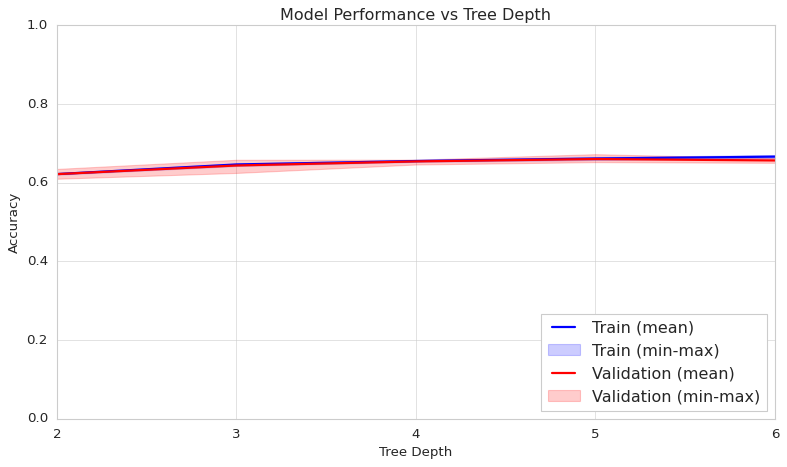

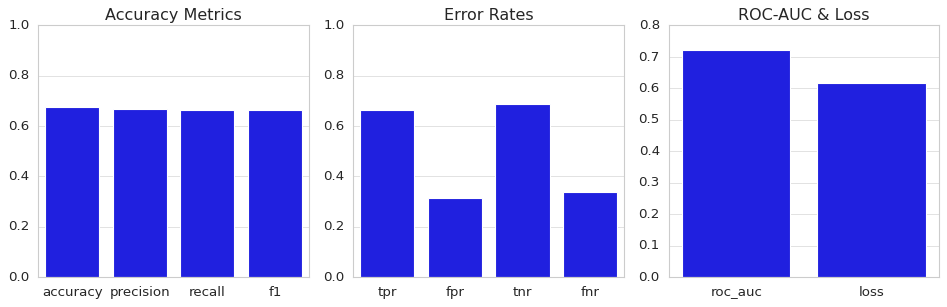

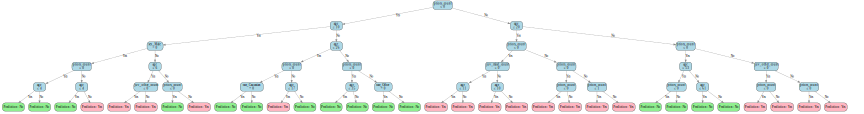


Model saved as: decision_tree_model_20250703_195923.joblib


In [60]:
# DECISION TREE

# Set initial parameters
params = {'criterion': 'entropy','min_samples_split': 20,'min_samples_leaf': 10,'random_state': 42}

# Run hyperparameter optimization and get evaluation results
min_td, max_td = 2, 6
optimization_evals, best_depth, depth_analysis = optimize_tree_depth(train_data, min_td=min_td, max_td=max_td, n_fold=5, params=params)

# Plot optimization results
opt_fig = plot_optimization_evals(optimization_evals)
plt.show()

# Train final model with best depth
params['max_depth'] = best_depth
model_dt = train_decision_tree(train_data, params=params)

# Evaluate and visualize final model performance
test_evals = test_model(model_dt, test_data)
eval_fig = plot_evals(test_evals)
plt.show()

# Generate and display tree visualization
tree_graph = tree_viz(model_dt)
display(tree_graph)

# Save final model
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'decision_tree_model_{timestamp}.joblib'
dump(model_dt, model_filename)
print(f'\nModel saved as: {model_filename}')

In [ ]:
# XB BOOST

# set parameters
params = ...

# run hyperparameter optimization for tree-depth using 5-fold crossvalidation
min_td, max_td = 2, 6
evals = optimize_tree_depth(train_data, min_td=min_td, max_td=max_td, n_fold=5,
  params=params)
fig = plot_optimization_evals(evals)
fig.show()

# set hyperparameters to best found value(i.e., tree depth)
params[...] = ...

# check crossvalidation results for optimal hyperparamters (i.e., optimal tree depth)
fig2 = plot_crossvalidation_evals(evals)
fig2.show()

# train with optimal hyperparameters (i.e., optimal tree depth)
model_dt = train_decision_tree(train_data, params=params)
evals = test_model(model_dt, test_data)

# show final tree
fig3 = tree_viz(model)
fig3.show()

# show evals for final tree
fig4 = plot_evals(evals)
fig4.show()

# save final model
# [add code here]

In [ ]:
# NEURAL NETWORK

# set parameters
params = ...

# run hyperparameter optimization using 5-fold crossvalidation

# [add code here]

# set hyperparameters
params[...] = ...

# check crossvalidation results for optimal hyperparameter values
fig2 = plot_crossvalidation_evals(evals)
fig2.show()

# train with optimal hyperparameters on full training set
model_nn = train_neural_network(train_data)
evals = test_model(model_nn, test_data)
fig3 = plot_evals(evals)
fig3.show()

# save final model
# [add code here]